### Data-driven optimization and decision making

### Final project

Juha Reinikainen

In [9]:
import pandas as pd
import numpy as np
import model
import data
import algorithm
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

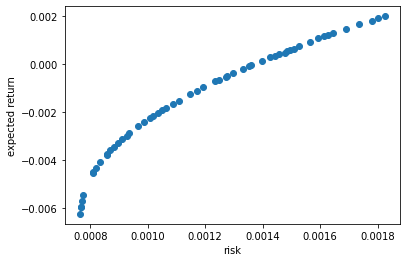

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


In [10]:
df = data.get_data_df()
w0 = np.array([0.25, 0.25, 0.25, 0.25])
problem = model.PortfolioSelection(df, w0)

P0 = algorithm.createWeightVectors(len(w0), 5)
repairMethod = algorithm.OneSumRepair()
nsga2 = NSGA2(pop_size = len(P0), sampling=P0, repair = repairMethod)
res = minimize(problem, nsga2, ("n_gen", 100), seed=1, verbose = False)

plt.scatter(res.F[:,1], -res.F[:,0])
plt.xlabel("risk")
plt.ylabel("expected return")
plt.show()

# print(res.X.sum(axis=1))

